<h4>Challenge: </h4>Binned Time of attack for Non-USA attacks (by country, region, overall)<br>

In [4]:
#Importing necessary  and the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import random
from collections import Counter

df = pd.read_excel("GSAF5-1.xls")

In [ ]:
#Creating a list of all countries and continents. Code adapted from similar code provided by Group 8
asia = ['Afghanistan', 'Bahrain', 'United Arab Emirates','Saudi Arabia', 'Kuwait', 'Qatar', 'Oman','Thailand'
'Sultanate of Oman','Lebanon', 'Iraq', 'Yemen', 'Pakistan', 'Lebanon', 'Philippines', 'Jordan','India','China','Mauritius']

europe = ['Germany','Spain', 'France', 'Italy', 'Netherlands', 'Norway', 'Sweden','Czech Republic', 'Finland',
'Denmark', 'Czech Republic', 'Switzerland', 'UK', 'UK&I', 'Poland', 'Greece','Austria',
'Bulgaria', 'Hungary', 'Luxembourg', 'Romania' , 'Slovakia', 'Estonia', 'Slovenia','Portugal',
'Croatia', 'Lithuania', 'Latvia','Serbia', 'Estonia', 'ME', 'Iceland' ]

africa = ['Morocco', 'Tunisia', 'South Africa','Africa', 'ZA', 'Kenya','Reunion Island','Libya','St Helena','Comoros',
          'Reunion','Cape Verde','mozambique']

australia = ['Australia','New Caledonia','New Caledonia','Solomon Islands', 'New Zealand', 'French Polynesia', 'Samoa', 'Fiji']

north_america = ['Argentina', 'Cayman Islands', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay',
'Peru', 'Suriname', 'Uruguay', 'Venezuela', 'Antigua and Barbuda', 'Bahamas', 'Barbados',
'Belize', 'Canada', 'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'El Salvador', 'Grenada', 'Guatemala',
'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Saint Kitts and Nevis', 'Saint Lucia',
'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 'USA']

south_america = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay',
'Peru', 'Suriname', 'Uruguay', 'Venezuela']


list_of_continents=['Asia','Europe','Africa','Australia','North America', 'South America']


list_of_species = ["bull shark", "lemon shark", "raggedtooth shark", "tawney nurse shark", "tiger shark",
                  "reef shark", "small shark", "black tipped shark", "caribbean reef shark",
                  "whaler shark", "copper shark", "dead blue shark", "sandtiger shark", "sevengill  shark", "cow shark",
                  "cow shark", "oceanic whitetip shark", "small spotted catshark", "brown shark", "angel shark",
                  "basking shark", "blue shark", "bronze whaler shark", "dusky shark", "galapagos shark", "goblin shark",
                  "nurse shark", "zambesi shark", "silky shark", "silvertip shark", "spurdog shark", "starry smoothhound shark"]

We begin by selecting relevant data from the data set. We limit the scope of our analysis to records from the last 20 years (records after 1999). We also disregard any records of attacks within the USA

In [4]:
#Selecting relevant data
temp = df[np.logical_and(df.Country !="USA", df.Country.notnull())]
shark_data = temp[np.logical_and(temp.Year>=1999, temp.Year.notnull())]
shark_data.columns = shark_data.columns.str.replace(" ", "")

In [5]:
#Removing data with null values in Time column
shark_data = shark_data[shark_data.Time.notnull()]

In [6]:
shark_data.columns

Index(['CaseNumber', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex', 'Age', 'Injury', 'Fatal(Y/N)', 'Time',
       'Species', 'InvestigatororSource', 'pdf', 'hrefformula', 'href',
       'CaseNumber.1', 'CaseNumber.2', 'originalorder', 'Unnamed:22',
       'Unnamed:23'],
      dtype='object')

We perform preprocessing on the data in the Time field of the dataset in order to bin the time into five discrete time segments: "early morning", "morning", "afternoon", "evening" and "night"<br>
We then create a new column in te dataframe called "Time_of_Day" to store these labels and then turn it into a categorical field.

In [7]:
#Applying time_rep to shark_data
#Function to replace null values with random values and replace alphanumeric strings to digit form
def time_rep(x):
    if pd.isnull(x):            
        x = str(random.randrange(0,2390, 10))    
    if "morning" in str(x).lower() or "dawn" in str(x).lower():
        x = str(random.randrange(600,1190,10))
    elif "afternoon" in str(x).lower() or "noon" in str(x).lower() or "am" in str(x).lower() or "a.m." in str(x).lower() or "day" in str(x).lower() or "time" in str(x).lower():
        x = str(random.randrange(1200,1790,10))
    elif "evening" in str(x).lower() or "dusk" in str(x).lower() or "p.m." in str(x).lower() or "sun" in str(x).lower():
        x = str(random.randrange(1800,2390,10))
    elif "night" in str(x).lower():
        x = str(random.randrange(0,590,10))
    x = re.sub('[^0-9]','', str(x))
    if len(x)<4:
        x = "0"+str(x)
    if len(x)>4:
        x = str(x)[:4]
    x = x.replace('h', '')
    return x
shark_data.Time=shark_data.Time.apply(time_rep)

In [8]:
#Creating a new column "Time_of_Day" to store the time labels of the data
#Function to separate time into five discrete segments: Morning, Afternoon, Evening, Night and Early Morning
def time_of_day(x):
    if int(x) >= 600 and int(x)<1200:
        x = "morning"
    elif int(x) >= 1200 and int(x)<1700:
        x = 'afternoon'
    elif int(x) >= 1600 and int(x)<2000:
        x = 'evening'
    elif (int(x) >= 2000 and int(x)<2390) or (int(x) >= 0 and int(x)<200):
        x = 'night'
    elif int(x) >= 200 and int(x)<600:
        x = 'early morning'
    return x
shark_data['Time_of_Day'] = shark_data.Time.apply(time_of_day)
shark_data.Time_of_Day = shark_data.Time_of_Day.astype('category')

Next, we work on the country field of the data. We create a new column called "Continent" and label data based on which continent it occurred in. For this, we create a repository of countries and continents.
Code taken from Group 8 and then adapted.

In [9]:
#Applying get_continent function to shark_data to group data into continents
#Function to segregate countries into continents
def get_continent(country):
    if country in asia:
        return "Asia"
    elif country in europe:
        return "Europe"
    elif country in africa:
        return "Africa"
    elif country in australia:
        return "Australia"
    elif country in north_america:
        return "North America"
    elif country in south_america:
        return "South America"
    else:
        return (np.random.choice(list_of_continents))


shark_data['Continent'] = shark_data['Country'].apply(lambda x: get_continent(x))

Finally, we move onto the fields of "Fatal (Y/N)" and Species. These fields help us understand the impact of these attacks and help us curb future conflict.

In [10]:
#Applying Cleaning functions to "Fatal(Y/N)" and "Species"
##Replacement of null values in "Fatal (Y/N)" with random values from the column.
def fatal_rep(x):        
    try:        
        if pd.isna(x):            
            rand_num = random.choice(shark_data['Fatal (Y/N)'][shark_data['Fatal (Y/N)'].notna()])                        
            return rand_num            
        elif x !='N' or x!='Y':
            rand_num = random.choice([x for x in ['Y','N']])                        
            return rand_num
        else:            
            return x        
    except Exception as e:
        return x


shark_data['Fatal(Y/N)'] = shark_data['Fatal(Y/N)'].apply(fatal_rep)

In [11]:
# randomly raplacing missing values to make sure there is no bias in the dataset
def species_rep_rand(x):        
    try:        
        if pd.isnull(x):            
            rand_species = random.choice(list_of_species)                        
            return rand_species            
        else:            
            return x        
    except Exception as e:
        return x

    
# Function to Clean up the "Species" column of the data
def species_rep(x):
    y = re.search("\d", x)
    if "bull" in str(x).lower():
        x = "bull shark"
    elif "lemon" in str(x).lower():
        x = "lemon shark"
    elif "raggedtooth" in str(x).lower():
        x = "raggedtooth shark"
    elif "tawney nurse" in str(x).lower():
        x = "tawney nurse shark"
    elif "tiger" in str(x).lower():
        x = "tiger shark"
    elif "reef" in str(x).lower():
        x = "reef shark"
    elif "white" in str(x).lower():
        x = "white shark"
    elif "small shark" in str(x).lower() or "small sharks" in str(x).lower():
        x = "small shark"
    elif "black tipped" in str(x).lower() or "Blacktip Reef" in str(x).lower():
        x = "black tipped shark"
    elif "caribbean reef" in str(x).lower():
        x = "caribbean reef shark"
    elif "whaler" in str(x).lower():
        x = "whaler shark"
    elif "copper" in str(x).lower():
        x = "copper shark"
    elif "dead blue" in str(x).lower():
        x = "dead blue shark"
    elif "sandtiger" in str(x).lower():
        x = "sandtiger shark"
    elif "sevengill" in str(x).lower() or "7-gill" in str(x).lower():
        x = "sevengill  shark"
    elif "cow" in str(x).lower():
        x = "cow shark"
    elif "oceanic whitetip" in str(x).lower():
        x = "oceanic whitetip shark"
    elif "small spotted" in str(x).lower():
        x = "small spotted catshark"
    elif "brown" in str(x).lower():
        x = "brown shark"
    elif "angel" in str(x).lower():
        x = "angel shark"
    elif "basking" in str(x).lower():
        x = "basking shark"
    elif "blue" in str(x).lower():
        x = "blue shark"
    elif "bronze whaler" in str(x).lower():
        x = "bronze whaler shark"
    elif "cookiecutter" in str(x).lower():
        x = "cookiecutter shark"
    elif "dusky" in str(x).lower():
        x = "dusky shark"
    elif "galapagos" in str(x).lower():
        x = "galapagos shark"
    elif "goblin" in str(x).lower():
        x = "goblin shark"
    elif "nurse" in str(x).lower():
        x = "nurse shark"
    elif "mako" in str(x).lower():
        x = "mako shark"
    elif "porbeagle" in str(x).lower():
        x = "porbeagle shark"
    elif "port Jackson" in str(x).lower():
        x = "port jackson shark"
    elif "hammerhead" in str(x).lower():
        x = "hammerhead shark"
    elif "zambesi" in str(x).lower():
        x = "zambesi shark"
    elif "starry smoothhound" in str(x).lower():
        x = "starry smoothhound shark"
    elif "spurdog" in str(x).lower():
        x = "spurdog shark"
    elif "silvertip" in str(x).lower():
        x = "silvertip shark"
    elif "silky" in str(x).lower():
        x = "silky shark"
    elif "not a shark" in str(x).lower():
        x = "not a shark"
    elif "invalid" in str(x).lower():
        x = "not a shark"
    elif "unidentified" in str(x).lower():
        x = "not a shark"
    elif "not confirmed" in str(x).lower():
        x = "unconfirmed"
    elif "questionable" in str(x).lower():
        x = "unconfirmed"
    elif "unconfirmed" in str(x).lower():
        x = "unconfirmed"
    elif "to be determined" in str(x).lower():
        x = "unconfirmed"
    elif "doubtful" in str(x).lower():
        x = "unconfirmed"
    elif pd.isna(x):
        x = random.choice(shark_data.Species[pd.notna(shark_data.Species)])    
    elif y:
        if int(x[y.start()])>=0 and int(x[y.start()])<1:
            x = 'Tiny Shark'      
        elif int(x[y.start()])>=1 and int(x[y.start()])<4:
            x = 'Small Shark'
        elif int(x[y.start()])>=4 and int(x[y.start()])<6:
            x = 'Medium Shark'
        elif int(x[y.start()])>=6:
            x = 'Large Shark'
    else:
        x = "other shark"
    
    
    re.sub("\D\d\s\S\w\W", "", str(x))
    return x


species = shark_data.Species[shark_data.Species.notna()].tolist()
list_of_species = list(set(np.asarray(species)))
shark_data.Species = shark_data.Species.apply(species_rep_rand)
shark_data.Species = shark_data.Species.apply(species_rep)

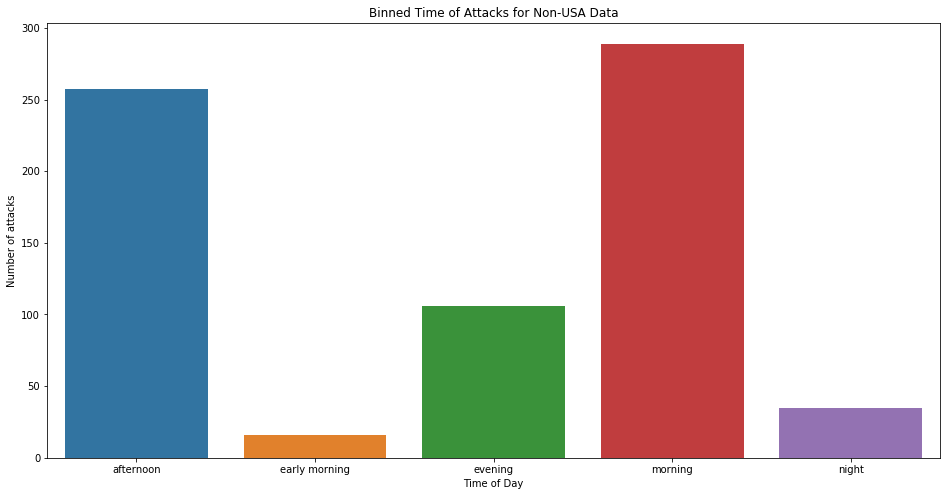

In [12]:
#Plotting the total number of attacks by binned time of day
plt.figure(figsize=(16, 8))
sns.countplot(x='Time_of_Day',data=shark_data).set_title('Binned Time of Attacks for Non-USA Data')
plt.xlabel('Time of Day')
plt.ylabel('Number of attacks')
plt.style.use(('ggplot'))

The above plot shows us that a majority of the attacks occur in the morning, that is, between 6:00AM and 12:00PM. The low number of attacks in the "early morning" time segment can likely be attributed to the lack of maritime activity between 12:00AM and 6:00AM.

Text(0.5, 0, 'Number of Attacks')

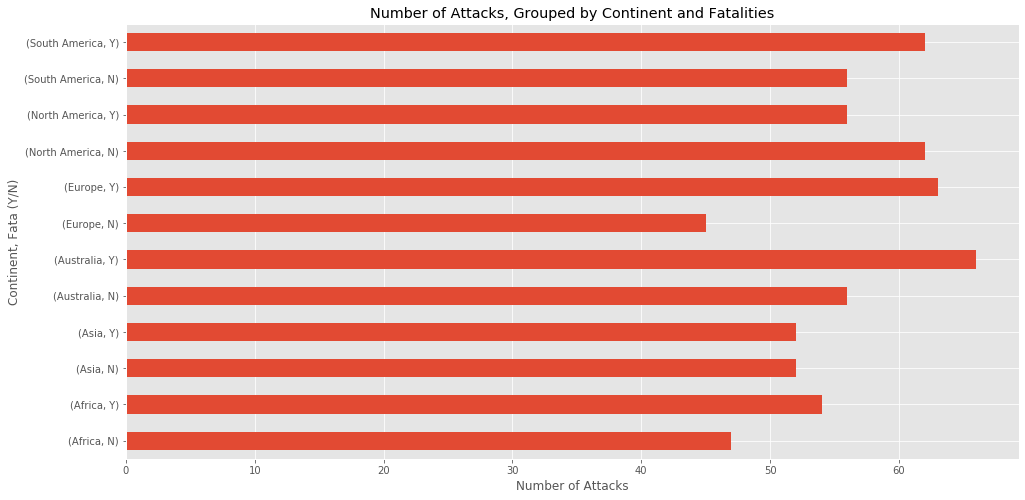

In [13]:
#Plotting the number of attacks grouped by Continent and Fatalities
plt.figure(figsize=(16, 8))
shark_data.groupby(['Continent', 'Fatal(Y/N)']).count()['Name'].plot(kind='barh',title='Number of Attacks, Grouped by Continent and Fatalities')
plt.ylabel('Continent, Fata (Y/N)')
plt.xlabel('Number of Attacks')

The above plot curiously shows us that shark attacks that occur in the continents of Asia and Australia are less likely to be fatal than those occurring in Africa, Europe or the Americas. This may be due to better planning and emergency services in the respective countries.

Text(0, 0.5, 'Number of Attacks')

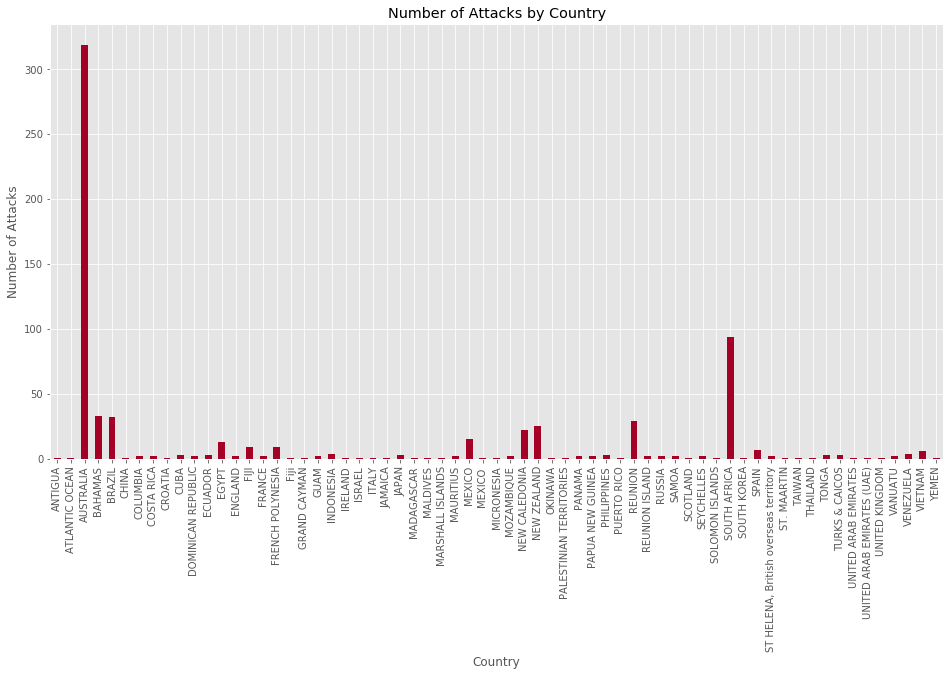

In [14]:
#Plotting the number of attacks by country
plt.figure(figsize=(16, 10))
shark_data.groupby(['Country']).count()['Name'].plot(kind='bar',title='Number of Attacks by Country',figsize=(16,8), cmap = "RdYlBu")
plt.xlabel('Country')
plt.ylabel('Number of Attacks')

The above plot shows spikes in countries that have more of a maritime culture. Countries such as Australia, New Zealanf and South Africa have notable surfing cultures.

Text(0, 0.5, 'Number of Attacks')

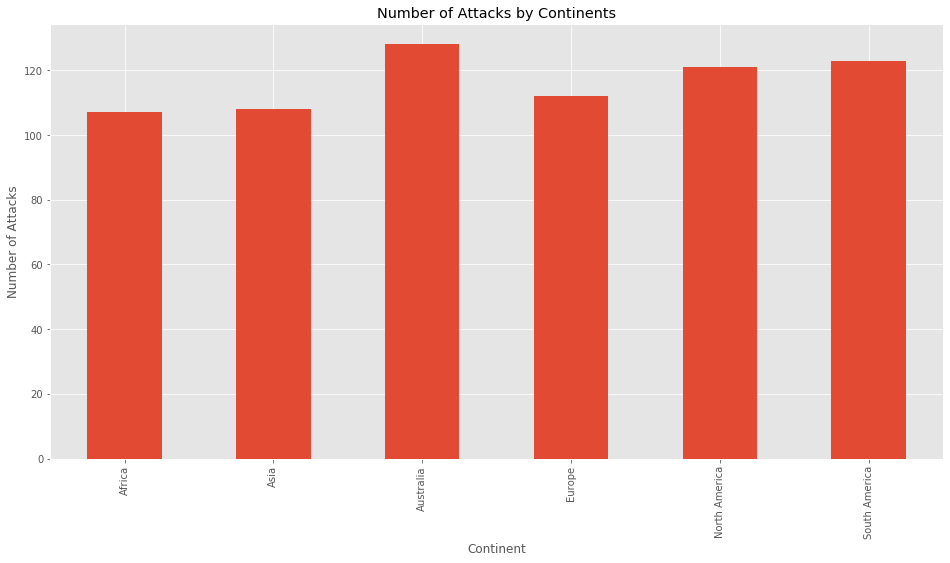

In [15]:
#Plotting the number of attacks by continent
plt.figure(figsize=(16, 6))
shark_data.groupby(['Continent']).count()['Name'].plot(kind='bar',title='Number of Attacks by Continents',figsize=(16,8))
plt.xlabel('Continent')
plt.ylabel('Number of Attacks')

This plot, in conjunction with the previous plot, gives us an idea about the sheer amount of shark attacks taking place in Australia. The above bar graph shows Australia (here, referring to the continent) in close contention for first place in terms of shark attack numbers. Keeping in mind that only a handful of countries can be considered to be a part of the continent of Australia or Oceania, the number of attacks is noteworthy. In addition, the previous plot clearly shows that Australia (here, reffering to the nation) bear the lions share of these attacks.

Text(0, 0.5, 'Species')

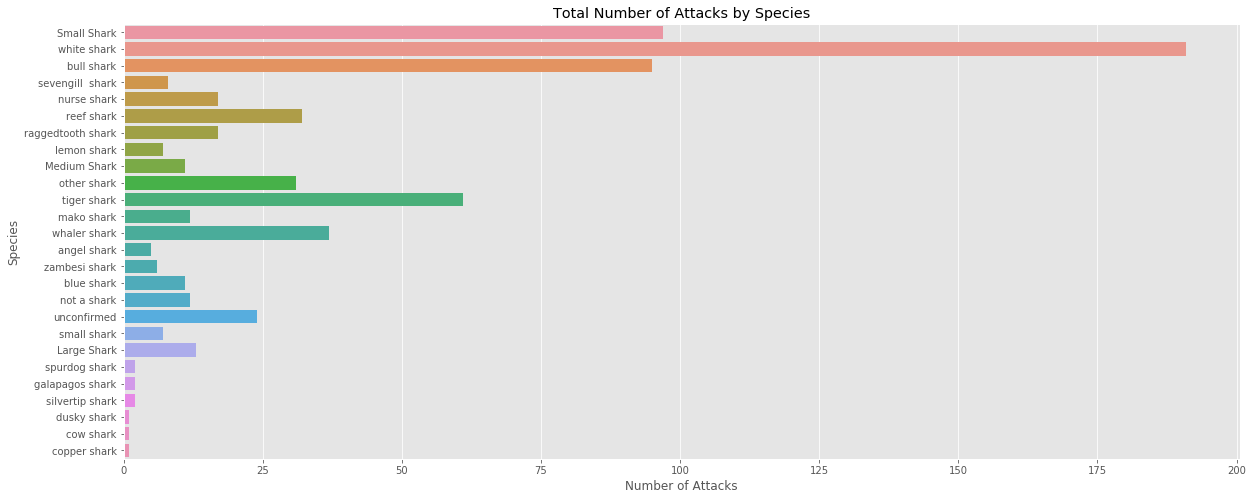

In [16]:
#Plotting the number of sharks attacks per species
plt.figure(figsize=(20, 8))
sns.countplot(y='Species',data=shark_data).set_title('Total Number of Attacks by Species')
plt.xlabel('Number of Attacks')
plt.ylabel('Species')

This final plot informs us about two things. Firstly, correctly identifying sharks in these cases is a difficult task and, secondly, that white shark species seem to have an affinity to attack humans.

Text(0, 0.5, 'Continent, Time of Day')

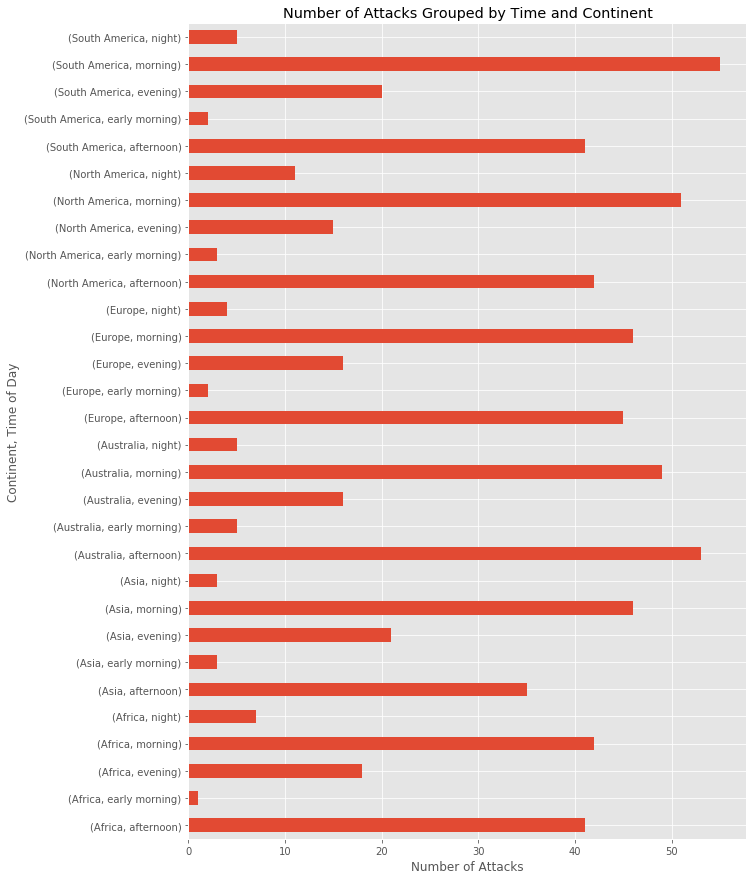

In [17]:
#Plotting the number of attacks, grouped by time and continent
groupByContinentData = shark_data.groupby(["Continent",'Time_of_Day'])
groupByContinentData.size().plot(kind='barh',title='Number of Attacks Grouped by Time and Continent',figsize=(10,15))
plt.xlabel('Number of Attacks')
plt.ylabel('Continent, Time of Day')

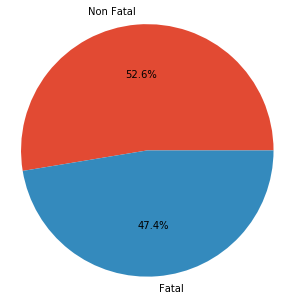

In [18]:
fatal_vals = shark_data['Fatal(Y/N)'].value_counts().tolist()
f, ax = plt.subplots(figsize=(5, 5))

labels = ['Non Fatal', 'Fatal']

plt.pie(fatal_vals, labels=labels,autopct='%1.1f%%')
 
axis = plt.axis('equal')

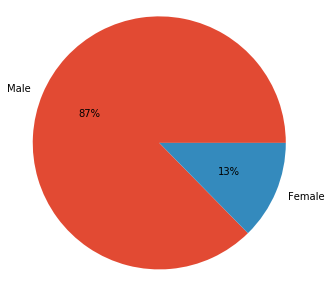

In [26]:
def sex_rep(sex):
    if sex == 'M' or sex == 'F':
        return sex
    else:
        return np.nan
shark_data['Sex'] = shark_data['Sex'].apply(lambda x: sex_rep(x))
sex_vals = shark_data['Sex'].value_counts().tolist()
f, ax = plt.subplots(figsize=(5, 5))

labels = ['Male', 'Female']

plt.pie(sex_vals, labels=labels,autopct='%1.0f%%')

axis = plt.axis('equal')


In [20]:
set(shark_data['Sex'])

{'F', 'M', nan}

Text(0, 0.5, 'Number of Deaths')

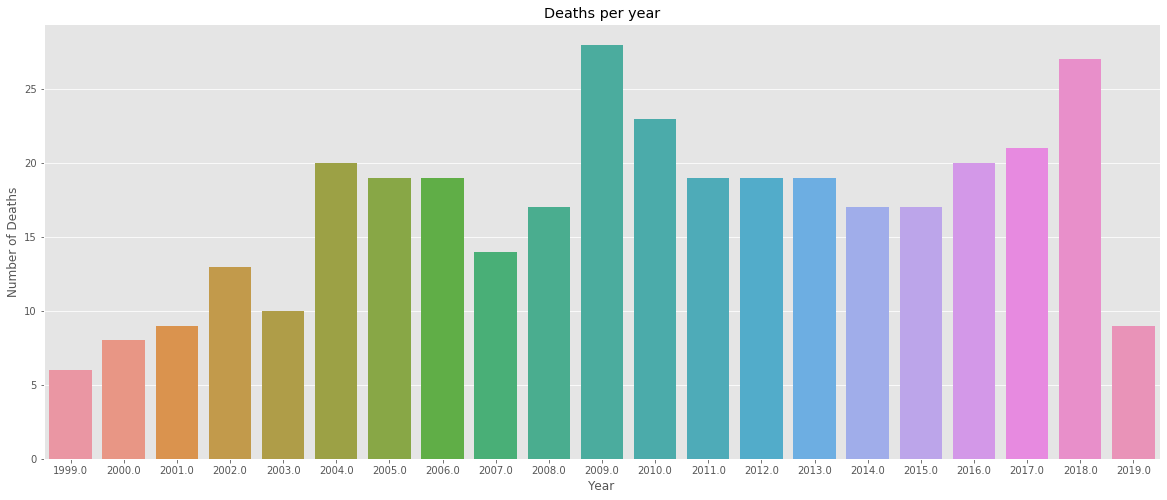

In [21]:
fig, ax = plt.subplots(figsize=(20, 8))
g = sns.countplot(x="Year", data=shark_data[(shark_data["Fatal(Y/N)"] == "Y")], 
                ).set_title('Deaths per year')
plt.ylabel('Number of Deaths')